# **CUSTOMER CHURN PREDICTION**

# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold,cross_val_predict,RandomizedSearchCV,cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix,accuracy_score,classification_report
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import utils, Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.activations import relu, sigmoid

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint



In [2]:
df = pd.read_csv('archive/Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
df.nunique()


RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values present.

In [6]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [7]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

# EDA

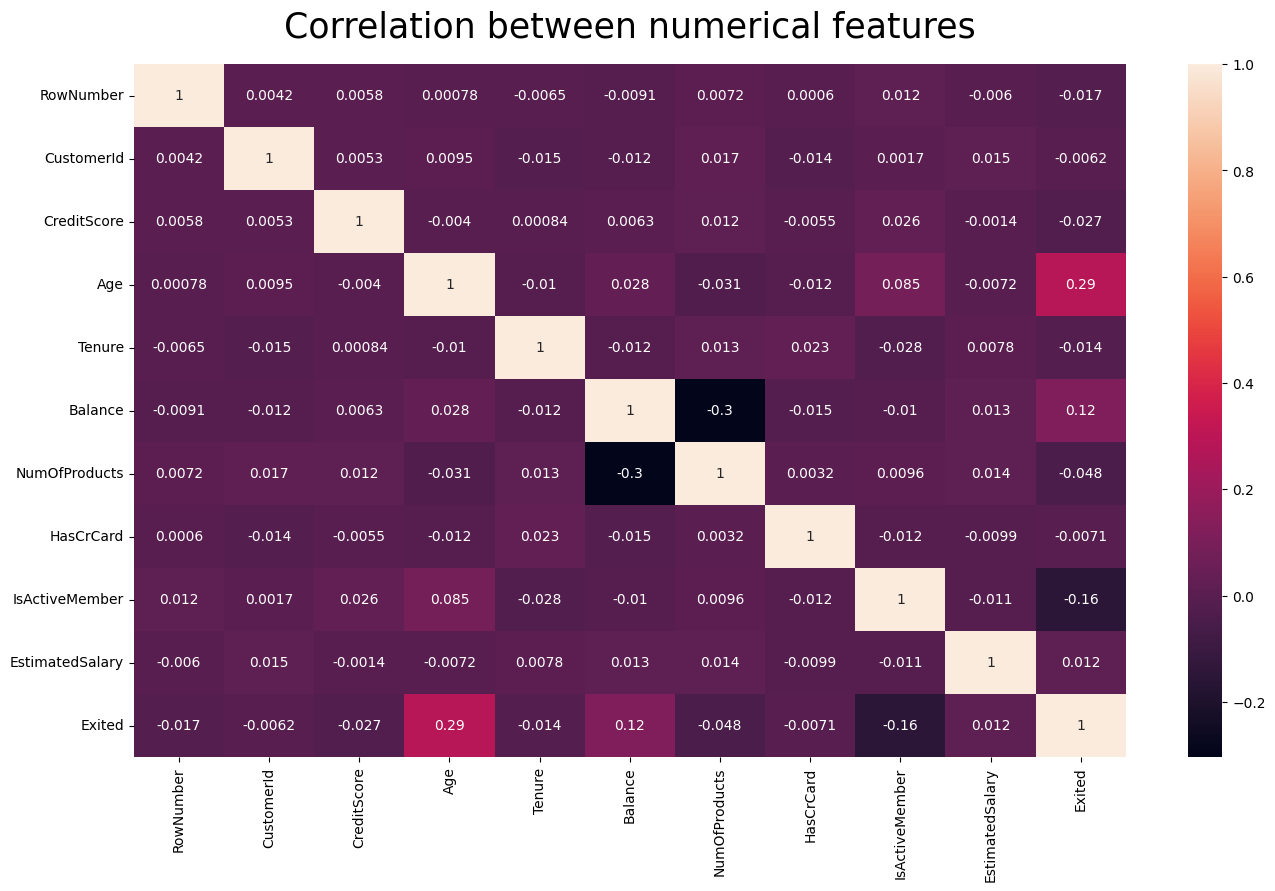

In [8]:
numeric_columns = df.select_dtypes(include=['number'])
corr = numeric_columns.corr()
plt.figure(figsize = [16,9])
plt.title("Correlation between numerical features", size = 25, pad = 20)
sns.heatmap(corr, annot = True)
plt.show()

**Age and Balance are positively correlated with Exited feature. 
IsActiveMember is negatively correlated with Exited.**

Text(0.5, 1.0, 'Genders Vs Customers')

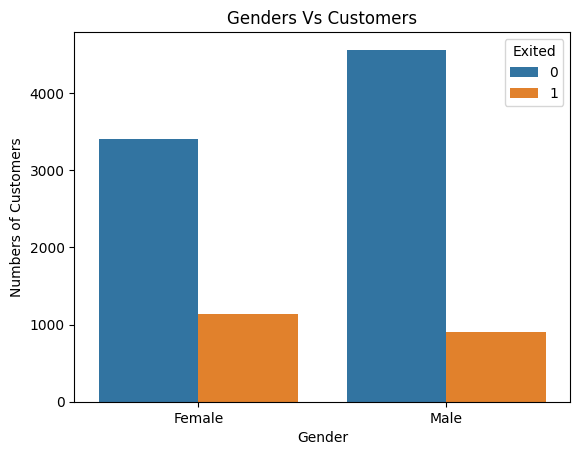

In [9]:
sns.countplot(x='Gender',hue='Exited',data=df)
plt.xlabel('Gender')
plt.ylabel('Numbers of Customers')
plt.title("Genders Vs Customers")

**Although the majority of customers are male, there isn't a significant gender-based difference in terms of churning.**

Text(0.5, 1.0, 'Geography Vs Customers')

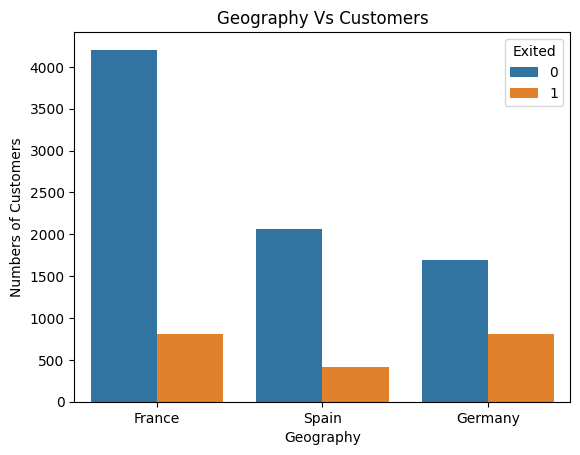

In [10]:
sns.countplot(x='Geography',hue='Exited',data=df)
plt.xlabel('Geography')
plt.ylabel('Numbers of Customers')
plt.title("Geography Vs Customers")

**Most of the customers are from France.
Germans and French are more likely to exit.**

# Data preprocessing

In [11]:
df.drop(columns=['Surname', 'CustomerId', 'RowNumber'], inplace=True)
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

**Bar Chart of correlation of different features with "Exited" feature**

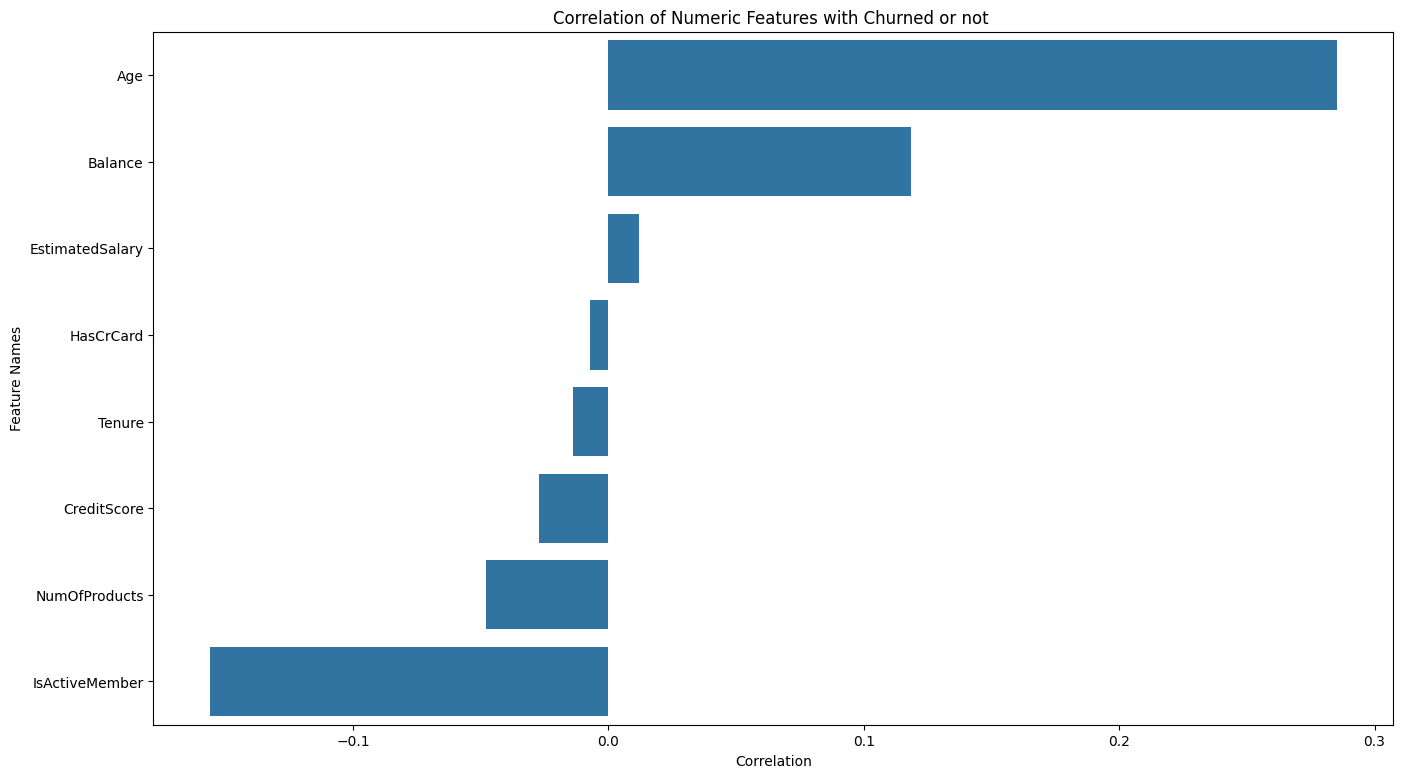

In [12]:
feature_corr = df.drop(columns='Exited').select_dtypes('number').apply(lambda x: x.corr(df['Exited']))
feature_corr = pd.DataFrame(feature_corr,columns = ['Correlation']).sort_values(['Correlation'],ascending = False)
plt.figure(figsize=(16,9))
sns.barplot(x=feature_corr['Correlation'], y=feature_corr.index).set(
title="Correlation of Numeric Features with Churned or not ", xlabel="Correlation",
ylabel="Feature Names")
plt.show()

**Converting into Range of values for some Numerical features**

**TENURE**

In [13]:
df.Tenure.value_counts()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64

In [14]:
labels = ["{0} - {1}".format(i,i+2) for i in range(0,11,2) ]
labels

['0 - 2', '2 - 4', '4 - 6', '6 - 8', '8 - 10', '10 - 12']

Text(0.5, 1.0, 'Tenure Vs Churning')

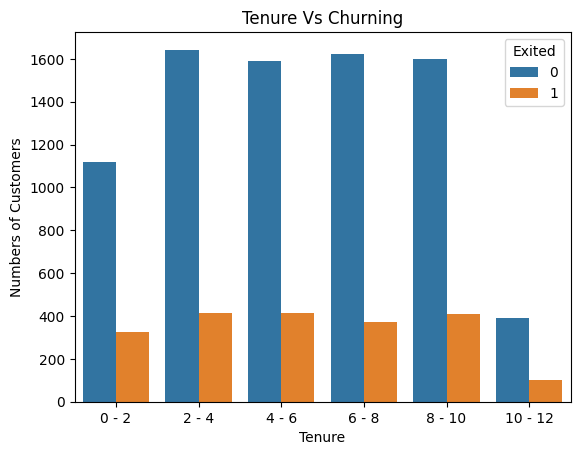

In [15]:
df["TenureGroup"] = pd.cut(df['Tenure'],range(0,13,2),labels =labels,right=False)
sns.countplot(x='TenureGroup',hue='Exited',data=df)
plt.xlabel('Tenure')
plt.ylabel('Numbers of Customers')
plt.title("Tenure Vs Churning")

**AGE**

In [16]:
df.Age.max()

92

Text(0.5, 1.0, 'Age Vs Churning')

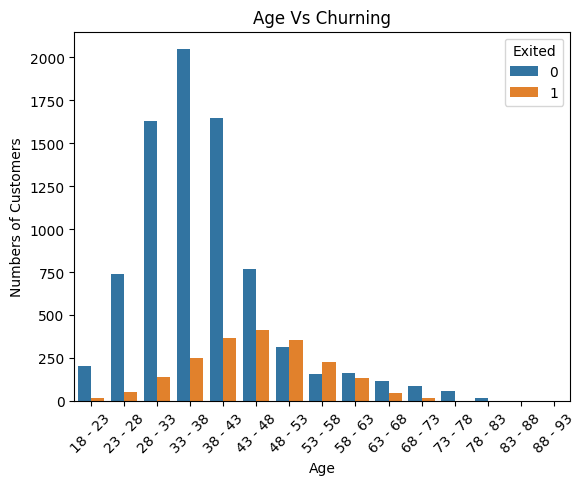

In [17]:
label = ["{0} - {1}".format(i,i+5) for i in range(18,93,5)]
df["AgeGroup"]=pd.cut(df['Age'],range(18,94,5),labels=label,right=False)
sns.countplot(x='AgeGroup',hue='Exited',data=df)
plt.xlabel('Age')
plt.xticks(rotation = 45)
plt.ylabel('Numbers of Customers')
plt.title("Age Vs Churning")

People from age group 43-48 are most likely to churn.

In [18]:
df.drop(columns=['Age',"Tenure"],inplace=True)

**One hot encoding of some categorical variables**

In [19]:
df = pd.get_dummies(df, columns=['Geography', 'Gender','TenureGroup','AgeGroup'], drop_first=True)

**Scaling numerical features because they have widely different range.**

In [20]:
ss = StandardScaler()
numeric_columns = ['CreditScore','Balance','EstimatedSalary']
df[numeric_columns] = ss.fit_transform(df[numeric_columns])

In [21]:
X=df.drop(columns = ['Exited'])
y=df['Exited']

# Training initial models 

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=420)
print(X_train.shape)
print(X_test.shape)

(7000, 28)
(3000, 28)


In [23]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.851

Confusion Matrix:
 [[2277  121]
 [ 326  276]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      2398
           1       0.70      0.46      0.55       602

    accuracy                           0.85      3000
   macro avg       0.78      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



In [24]:
xgb_c = xgb.XGBClassifier()
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_x)
conf_matrix = confusion_matrix(y_test, y_pred_x)
classification_rep = classification_report(y_test, y_pred_x)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.8493333333333334

Confusion Matrix:
 [[2260  138]
 [ 314  288]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2398
           1       0.68      0.48      0.56       602

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.84      0.85      0.84      3000



# Neural Network

In [25]:
X_train.dtypes

CreditScore            float64
Balance                float64
NumOfProducts            int64
HasCrCard                int64
IsActiveMember           int64
EstimatedSalary        float64
Geography_Germany         bool
Geography_Spain           bool
Gender_Male               bool
TenureGroup_2 - 4         bool
TenureGroup_4 - 6         bool
TenureGroup_6 - 8         bool
TenureGroup_8 - 10        bool
TenureGroup_10 - 12       bool
AgeGroup_23 - 28          bool
AgeGroup_28 - 33          bool
AgeGroup_33 - 38          bool
AgeGroup_38 - 43          bool
AgeGroup_43 - 48          bool
AgeGroup_48 - 53          bool
AgeGroup_53 - 58          bool
AgeGroup_58 - 63          bool
AgeGroup_63 - 68          bool
AgeGroup_68 - 73          bool
AgeGroup_73 - 78          bool
AgeGroup_78 - 83          bool
AgeGroup_83 - 88          bool
AgeGroup_88 - 93          bool
dtype: object

In [26]:
y_train.dtypes

dtype('int64')

In [27]:
X_train = X_train.astype(int)  
X_test = X_test.astype(int)  

model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=6, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.1, verbose=0)

y_pred_prob = model.predict(X_test)
y_pred_nn = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_nn)
conf_matrix = confusion_matrix(y_test, y_pred_nn)
classification_rep = classification_report(y_test, y_pred_nn)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

94/94 [==============================] - 0s 2ms/step
Accuracy: 0.8526666666666667

Confusion Matrix:
 [[2275  123]
 [ 319  283]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2398
           1       0.70      0.47      0.56       602

    accuracy                           0.85      3000
   macro avg       0.79      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



# Hyperparameter Optimization

**Random Forest Classifier Hyperparameter Optimization**

In [28]:
param_grid_rf = {
    "n_estimators":range(10,150,10) , #number of trees in forest randint(low=10, high=100)
    "max_depth":range(2,20,2)       #depth of each tree   randint(low=2, high=20)
} 

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=50,                     #tries 50 combo of hyperparameters
    verbose=1,                     #displays some info as i
    scoring='accuracy',
    random_state=123,
    return_train_score=True,
)
X=df.drop(columns = ['Exited'])
y=df['Exited']
random_search_rf.fit(X_train, y_train) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': range(2, 20, 2),
                                        'n_estimators': range(10, 150, 10)},
                   random_state=123, return_train_score=True,
                   scoring='accuracy', verbose=1)

In [29]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values:  {'n_estimators': 110, 'max_depth': 14}
Best score: 0.858


**XGBoost hyperparameter optimization**

In [30]:
param_grid_xgb = {
     'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

In [31]:

xg =xgb.XGBClassifier()
random_search_xgboost = RandomizedSearchCV(
    estimator = xg,
    param_distributions = param_grid_xgb,
    n_iter = 10,
    verbose =1,
    n_jobs=1,
    scoring="accuracy",
    random_state = 321,
    return_train_score=True,
)
random_search_xgboost.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=1,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.5, 0.7, 1]},
                   random_state=321, return_train_score=True,
                   scoring='accuracy', verbose=1)

In [32]:
print("Best hyperparameter values: ", random_search_xgboost.best_params_)
print("Best score: %0.3f" % (random_search_xgboost.best_score_))

Best hyperparameter values:  {'subsample': 1, 'max_depth': 3, 'learning_rate': 0.1}
Best score: 0.865


In [34]:
np.random.seed(42)

In [39]:
!pip install scikeras[tensorflow]

In [36]:
X_train.nunique()

CreditScore            6
Balance                4
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary        3
Geography_Germany      2
Geography_Spain        2
Gender_Male            2
TenureGroup_2 - 4      2
TenureGroup_4 - 6      2
TenureGroup_6 - 8      2
TenureGroup_8 - 10     2
TenureGroup_10 - 12    2
AgeGroup_23 - 28       2
AgeGroup_28 - 33       2
AgeGroup_33 - 38       2
AgeGroup_38 - 43       2
AgeGroup_43 - 48       2
AgeGroup_48 - 53       2
AgeGroup_53 - 58       2
AgeGroup_58 - 63       2
AgeGroup_63 - 68       2
AgeGroup_68 - 73       2
AgeGroup_73 - 78       2
AgeGroup_78 - 83       2
AgeGroup_83 - 88       2
AgeGroup_88 - 93       2
dtype: int64

In [42]:
import keras
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

input_dim = X_train.shape[1]

def create_model(neurons=8, hidden_layers=1, learning_rate=0.01, layers=None, optimizer='adam'):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    if layers:
        for layer_neurons in layers:
            model.add(keras.layers.Dense(layer_neurons, activation='relu'))
    else:
        for _ in range(hidden_layers):
            model.add(keras.layers.Dense(neurons, activation='relu'))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras_model = KerasClassifier(model=create_model,neurons=8,hidden_layers=1,learning_rate=0.01, epochs=84, batch_size=32, verbose=1)

param_dist = {
    'neurons': [6, 8, 16],
    'hidden_layers': [1, 2],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [5, 10, 15, 20, 25],
}

random_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_dist, n_iter=6, cv=3, scoring='accuracy')
random_result = random_search.fit(X_train, y_train)

print("Best parameters found: ", random_result.best_params_)
print("Best accuracy found: ", random_result.best_score_)


Epoch 1/10
146/146 [==============================] - 1s 2ms/step - loss: 0.5570 - accuracy: 0.7634
Epoch 2/10
146/146 [==============================] - 0s 2ms/step - loss: 0.5063 - accuracy: 0.7943
Epoch 3/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4796 - accuracy: 0.7951
Epoch 4/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4555 - accuracy: 0.7998
Epoch 5/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.8172
Epoch 6/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8210
Epoch 7/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8305
Epoch 8/10
146/146 [==============================] - 0s 3ms/step - loss: 0.4083 - accuracy: 0.8313
Epoch 9/10
146/146 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.8328
Epoch 10/10
73/73 [==============================] - 0s 1ms/step
Epoch 1/10
146/146 [===============

# Models Training

In [43]:
X_train = X_train.astype(int)  
X_test = X_test.astype(int)  

model = Sequential()
model.add(Dense(units=16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=15,batch_size=16, validation_data=(X_test, y_test), verbose=1)

y_pred_nn = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_nn)

conf_matrix = confusion_matrix(y_test, y_pred_nn)
classification_rep = classification_report(y_test, y_pred_nn,zero_division=1)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Epoch 1/15
438/438 [==============================] - 2s 4ms/step - loss: 0.4280 - accuracy: 0.8137 - val_loss: 0.4031 - val_accuracy: 0.8250
Epoch 2/15
438/438 [==============================] - 1s 3ms/step - loss: 0.3868 - accuracy: 0.8390 - val_loss: 0.3795 - val_accuracy: 0.8437
Epoch 3/15
438/438 [==============================] - 2s 3ms/step - loss: 0.3595 - accuracy: 0.8550 - val_loss: 0.3642 - val_accuracy: 0.8490
Epoch 4/15
438/438 [==============================] - 2s 4ms/step - loss: 0.3493 - accuracy: 0.8594 - val_loss: 0.3779 - val_accuracy: 0.8463
Epoch 5/15
438/438 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.8597 - val_loss: 0.3716 - val_accuracy: 0.8503
Epoch 6/15
438/438 [==============================] - 1s 3ms/step - loss: 0.3398 - accuracy: 0.8606 - val_loss: 0.3559 - val_accuracy: 0.8580
Epoch 7/15
438/438 [==============================] - 1s 3ms/step - loss: 0.3387 - accuracy: 0.8634 - val_loss: 0.3540 - val_accuracy: 0.8550
Epoch 

In [44]:
rf_classifier = RandomForestClassifier(n_estimators=110, max_depth=14)
rf_classifier.fit(X_train,y_train)
y_pred = rf_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
c_m= confusion_matrix(y_test,y_pred)
print("Validation accuracy = ",np.mean(acc)*100)
print(classification_report(y_test,y_pred))
print(c_m)

Validation accuracy =  84.7
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2398
           1       0.71      0.40      0.51       602

    accuracy                           0.85      3000
   macro avg       0.79      0.68      0.71      3000
weighted avg       0.83      0.85      0.83      3000

[[2301   97]
 [ 362  240]]


In [45]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=62, subsample=1)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
c_m = confusion_matrix(y_test, y_pred)

print("Validation accuracy =", np.mean(acc) * 100)
print("Confusion Matrix:\n", c_m)
print("Classification Report:\n", classification_report(y_test, y_pred))


Validation accuracy = 86.03333333333333
Confusion Matrix:
 [[2333   65]
 [ 354  248]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2398
           1       0.79      0.41      0.54       602

    accuracy                           0.86      3000
   macro avg       0.83      0.69      0.73      3000
weighted avg       0.85      0.86      0.84      3000



Decided to go with the Neural network.

The model achieved an accuracy of 85%, successfully identifying 87% of non-churn cases and 46% of churn cases. The confusion matrix indicates 2273 correct non-churn predictions and 276 correct churn predictions out of 3000 instances. The model demonstrates proficiency in recognizing non-churn instances, but its performance is relatively lower in identifying churn instances.